## Analyze Type 1 & Type 2 Diabetes Patients

##### Setup the imports.

In [149]:
import site, sys
sys.path.insert(0,site.USER_SITE)

from pyqe import *

##### Always start with creating a query object. 

Apart from creating Query object, it does the following that are required for setting up your profile:
- Ask for username and password for login

In [147]:
# Always begin your script by creating Query object
total_patients_query = Query('Total_Participants')

##### Configure by selecting Study and Study config.

Use get_study_list() method to fetch all available studies that you have access to.

Use set_study() method to select a study that you are interested in (by passing the study ID).

In [150]:
total_patients_query.get_study_list()

# any STUDY_ID from above list
total_patients_query.set_study('0368b0c9-fe26-4a64-b6ba-5378914fe107') 

Study Name - Study Id
(1) Accept - fb4269d3-f6ac-4f81-85da-b80ce277793e
(2) CRONOS by DGPM - 38ce29c0-eb76-45cc-ba4f-56395f8c49e0
(3) DE-SynPUF [Demo Dataset] - 0368b0c9-fe26-4a64-b6ba-5378914fe107
(4) Demo Study: COVID-19 symptom study - 121ec9da-3706-4e20-885d-101a7e421ed2
(5) ECOV - f875fdc4-c180-45f3-bdbb-a68fb1476338
(6) FeMFit - 69990b1e-3b4c-4e7f-9d06-84cc2cdf88d0
(7) S4H HPIMS - 62ce796d-f38a-4dab-95b9-00d202ece4fe
(8) Univie Demo-Study - 0b7e9885-ed8e-456f-89e1-0a1d3b0f615c


Similar to above step, use get_config_list() method to fetch all available configurations corresponding to the study.

Use set_study_config() method to select a config (by passing the config ID).

In [105]:
total_patients_query.get_config_list()

# any CONFIG_ID from above list
total_patients_query.set_study_config('522bcd53-1dde-456d-9cff-266b4280ad59') 

Assignment Name, Config Name - Config Id
(1) Default_assignment_OMOP_GDM_PA_CONF, OMOP_GDM_PA_CONF - 522bcd53-1dde-456d-9cff-266b4280ad59
(2) GDM-PA, DemoGDMPAConfig - daac6e40-9fdc-48f8-bd9b-181571102d91
(3) RKI-SYNPUF1K-PA, SYNPUF1K-PA - 695f3b81-2289-4b78-9527-7a610c0ce948
(4) S4H-HPIMS-Study, S4H-MS-PA-Config - 14356623-1766-4acb-9e16-9285d47bb71c
(5) Univie-Demo-Study, S4H-DemoData-PA-Config - 960abc83-cbef-4ace-9627-c60852d7a723


##### Initialize Patient object and add filter criteria

In [152]:
patients = Person.Patient()

constraint_age_greater_than_50_years = Constraint()
constraint_age_greater_than_50_years.add(Expression(ComparisonOperator.MORE_THAN_EQUAL, 50))

constraint_age_lesser_than_90_years = Constraint()
constraint_age_lesser_than_90_years.add(Expression(ComparisonOperator.LESS_THAN_EQUAL, 90))

patients.add_age([constraint_age_greater_than_50_years])
patients.add_age([constraint_age_lesser_than_90_years])

##### Define criteria for Type 2 Diabetes

In [109]:
# Condition Concept IDs for Diabetes Mellitus 2

diabetes2_conditionOcc = Interactions.ConditionOccurrence("Type 2 Diabetes condition")
diabetes2_condition_concepts = ConceptSet(
                           'Conditions',
                            Domain.CONDITION, 
                           ['44054006', '8801005', '190331003', '421326000', '443694000', '422014003', '421326000']) 

diabetes2_conditionOcc.add_concept_set(diabetes2_condition_concepts)

##### Define criteria for Type 1 Diabetes

In [110]:
# Diabetes type 1

diabetes1_conditionOcc = Interactions.ConditionOccurrence("Type 1 Diabetes condition")
diabetes1_condition_concepts = ConceptSet(
                           'Conditions',
                            Domain.CONDITION, 
                           ['201254', '318712', '435216', '40484648', '200687', '377821']) 
diabetes1_conditionOcc.add_concept_set(diabetes1_condition_concepts)

##### Combine Patient and Diabetes filter criteria

In [153]:
# patient_criteriagroup = CriteriaGroup(MatchCriteria.ALL, [patients, exclude_Death])
patient_criteriagroup = CriteriaGroup(MatchCriteria.ALL, [patients])


diabetes_criteriagroup = CriteriaGroup(
                        MatchCriteria.ANY, [diabetes1_conditionOcc, diabetes2_conditionOcc])

patient_criteriagroup.add_exclusive_group(diabetes_criteriagroup)
total_patients_query.add_criteria_group(patient_criteriagroup)

##### Get Patient count for the defined cohort

In [154]:
# create Result object and fetch the patient count
total_patients_req = total_patients_query.get_patient_count_filter()
total_patients = Result().get_patient_count(total_patients_req)
print(f'\nTotal participants: {total_patients}')


Total participants: 474


##### Get Dataframe for Patient entity alone

In [156]:
# Generate Request for Dataframe cohort
request_df = total_patients_query.get_dataframe_cohort([],'Patient')

# Get Patient Dataframe. Select (1) Patient
patient_df = Result().download_dataframe(request_df)

# Peek Into the Patient Demographics Data
selective_patient_df = patient_df[['pid', 'gender', 'dateofbirth', 'ethnicity', 'race', 'state']]

selective_patient_df.head(10)

,pid,gender,dateofbirth,ethnicity,race,state
0,2,MALE,1943-01-01,Not Hispanic or Latino,White,PA
1,3,FEMALE,1936-09-01,Not Hispanic or Latino,White,PA
2,4,MALE,1941-06-01,Hispanic or Latino,No matching concept,CO
3,5,MALE,1936-08-01,Not Hispanic or Latino,White,WI
4,6,MALE,1943-10-01,Not Hispanic or Latino,Black or African American,NY
5,8,MALE,1935-09-01,Not Hispanic or Latino,White,MN
6,11,FEMALE,1934-02-01,Not Hispanic or Latino,White,IN
7,13,FEMALE,1936-07-01,Not Hispanic or Latino,White,RI
8,14,MALE,1934-05-01,Not Hispanic or Latino,White,IL
9,15,FEMALE,1936-03-01,Not Hispanic or Latino,White,ID


##### Define the Necessary columns required for our analysis and get their data. Patient ID, Interactions End date, Date of death are some of the below ones.

In [158]:
specific_columns = total_patients_query.get_entities_dataframe_cohort(['patient.attributes.pid','patient.attributes.Gender', 
                                                                       'patient.attributes.dateOfBirth',
                                                                       'patient.interactions.conditionoccurrence.attributes.conditionname', 
                                                                       'patient.interactions.conditionoccurrence.attributes.startdate',
                                                                       'patient.interactions.conditionoccurrence.attributes.enddate',
                                                                       'patient.interactions.visit.attributes.enddate',
                                                                       'patient.interactions.proc.attributes.procdate',
                                                                       'patient.interactions.observation.attributes.obsdate',
                                                                       'patient.interactions.measurement.attributes.measurementdate',
                                                                       'patient.interactions.drugexposure.attributes.enddate',
                                                                       'patient.interactions.deviceexposure.attributes.enddate',
                                                                       'patient.interactions.death.attributes.deathdate'])

specified_dfs = Result().download_all_entities_dataframe(specific_columns)

##### Combine data from different Interaction entities for end date and choose patient's last interaction end date / Max End Date.

In [119]:
import pandas as pd

concatenated_dfs = pd.concat([
                                specified_dfs['measurement'].rename(columns={'measurementdate': 'enddate'}), 
                                specified_dfs['deviceexposure'],
                                specified_dfs['visit'],
                                specified_dfs['proc'].rename(columns={'procdate': 'enddate'}),
                                specified_dfs['observation'].rename(columns={'obsdate': 'enddate'}),
                                specified_dfs['ConditionOccurrence'],
                                specified_dfs['drugexposure']

])
concatenated_dfs_max_enddate = concatenated_dfs.groupby(['pid'],as_index=False)['enddate'].max().reindex(columns=['pid', 'enddate'])
concatenated_dfs_max_enddate.head(10)

,pid,enddate
0,2,2010-09-08
1,3,2009-11-17
2,4,2009-11-25
3,5,2010-05-26
4,6,2010-09-26
5,8,2010-03-02
6,11,2010-12-12
7,13,2010-09-22
8,14,2010-05-09
9,15,2010-12-01


##### Filter the Diabetes condition and choose the patients earliest date of diagnosis / Minimum start date

In [120]:
condOcc_df = specified_dfs['ConditionOccurrence']
condOcc_diabetes_df = condOcc_df[condOcc_df['conditionname'].str.contains("diabetes")]
co_pid_start_date_df = condOcc_diabetes_df[['pid', 'startdate']]
co_pid_groupby_start_date_min_df = co_pid_start_date_df.groupby(['pid'],as_index=False)['startdate'].min().reindex(columns=['pid', 'startdate'])
co_pid_groupby_start_date_min_df.head(10)

,pid,startdate
0,2,2009-05-11
1,3,2009-11-17
2,4,2009-11-25
3,5,2009-06-28
4,6,2009-12-21
5,8,2008-10-17
6,11,2008-06-17
7,13,2008-03-05
8,14,2008-05-24
9,15,2008-09-24


##### Form the table with surival period and binary values for dead or alive for the cohort for Kaplan Meier Analysis

In [159]:
import pandas as pd
death_df = specified_dfs['death']
joined_death_condOcc_df = pd.merge(co_pid_groupby_start_date_min_df, death_df, on='pid', how='left')
joined_death_start_end_df = pd.merge(joined_death_condOcc_df, concatenated_dfs_max_enddate, on='pid', how='inner')
joined_death_start_end_df['Dead'] =  joined_death_start_end_df.apply(lambda row: 0 if pd.isnull(row['deathdate']) else 1, axis=1)
joined_death_start_end_df['Survival_days'] = joined_death_start_end_df.apply(lambda row: (pd.to_datetime(row['enddate']) - pd.to_datetime(row['startdate'])).days if pd.isnull(row['deathdate']) else (pd.to_datetime(row['deathdate']) - pd.to_datetime(row['startdate'])).days, axis=1)

joined_death_start_end_df = joined_death_start_end_df.sort_values(by=['Survival_days'], ascending=True)
joined_death_start_end_df.head(10)

,pid,startdate,deathdate,enddate,Dead,Survival_days
1,3,2009-11-17,NaN,2009-11-17,0,0
2,4,2009-11-25,NaN,2009-11-25,0,0
315,755,2010-08-31,NaN,2010-08-31,0,0
163,385,2010-02-12,NaN,2010-02-12,0,0
394,924,2010-12-21,NaN,2010-12-30,0,9
72,166,2008-06-17,2008-07-01,2008-06-17,1,14
369,867,2010-04-26,NaN,2010-05-30,0,34
186,451,2010-01-16,NaN,2010-02-23,0,38
303,728,2010-06-30,NaN,2010-08-14,0,45
397,931,2010-10-15,NaN,2010-12-04,0,50


### Kapalan Meier 

##### With the above dataframe and using the lifelines library, Kapalan Meier Survival curve is plotted along with censor ticks on display. 
##### With Date of diagnosis for Diabetes as start event and date of death as the end event.

##### From the below curve, the survival looks quite good after diagnosis of Diabetes.

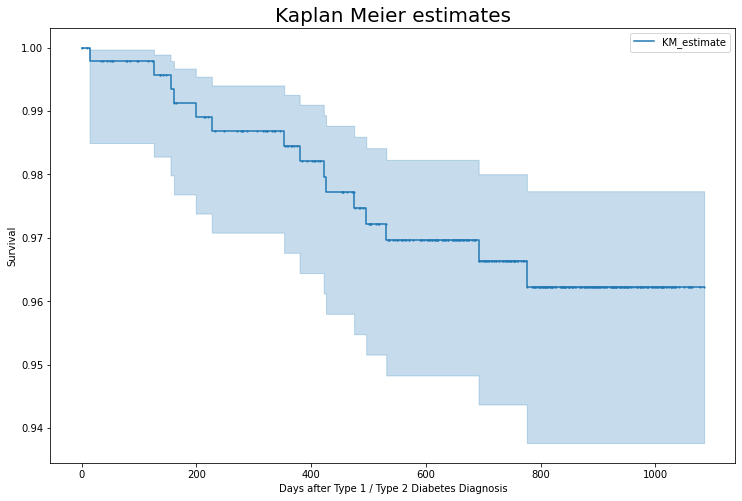

In [160]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
T = joined_death_start_end_df['Survival_days']
E = joined_death_start_end_df['Dead']
kmf.fit(T, event_observed=E)  # or, more succinctly, kmf.fit(T, E)
plt.figure(figsize=(27,8))
ax1 = plt.subplot(121)

kmf.plot_survival_function(show_censors=True, ax=ax1, censor_styles={'ms': 1, 'marker': 's'})

plt.title("Kaplan Meier estimates", fontdict={'fontsize':20})
plt.xlabel("Days after Type 1 / Type 2 Diabetes Diagnosis")
plt.ylabel("Survival")
plt.show()

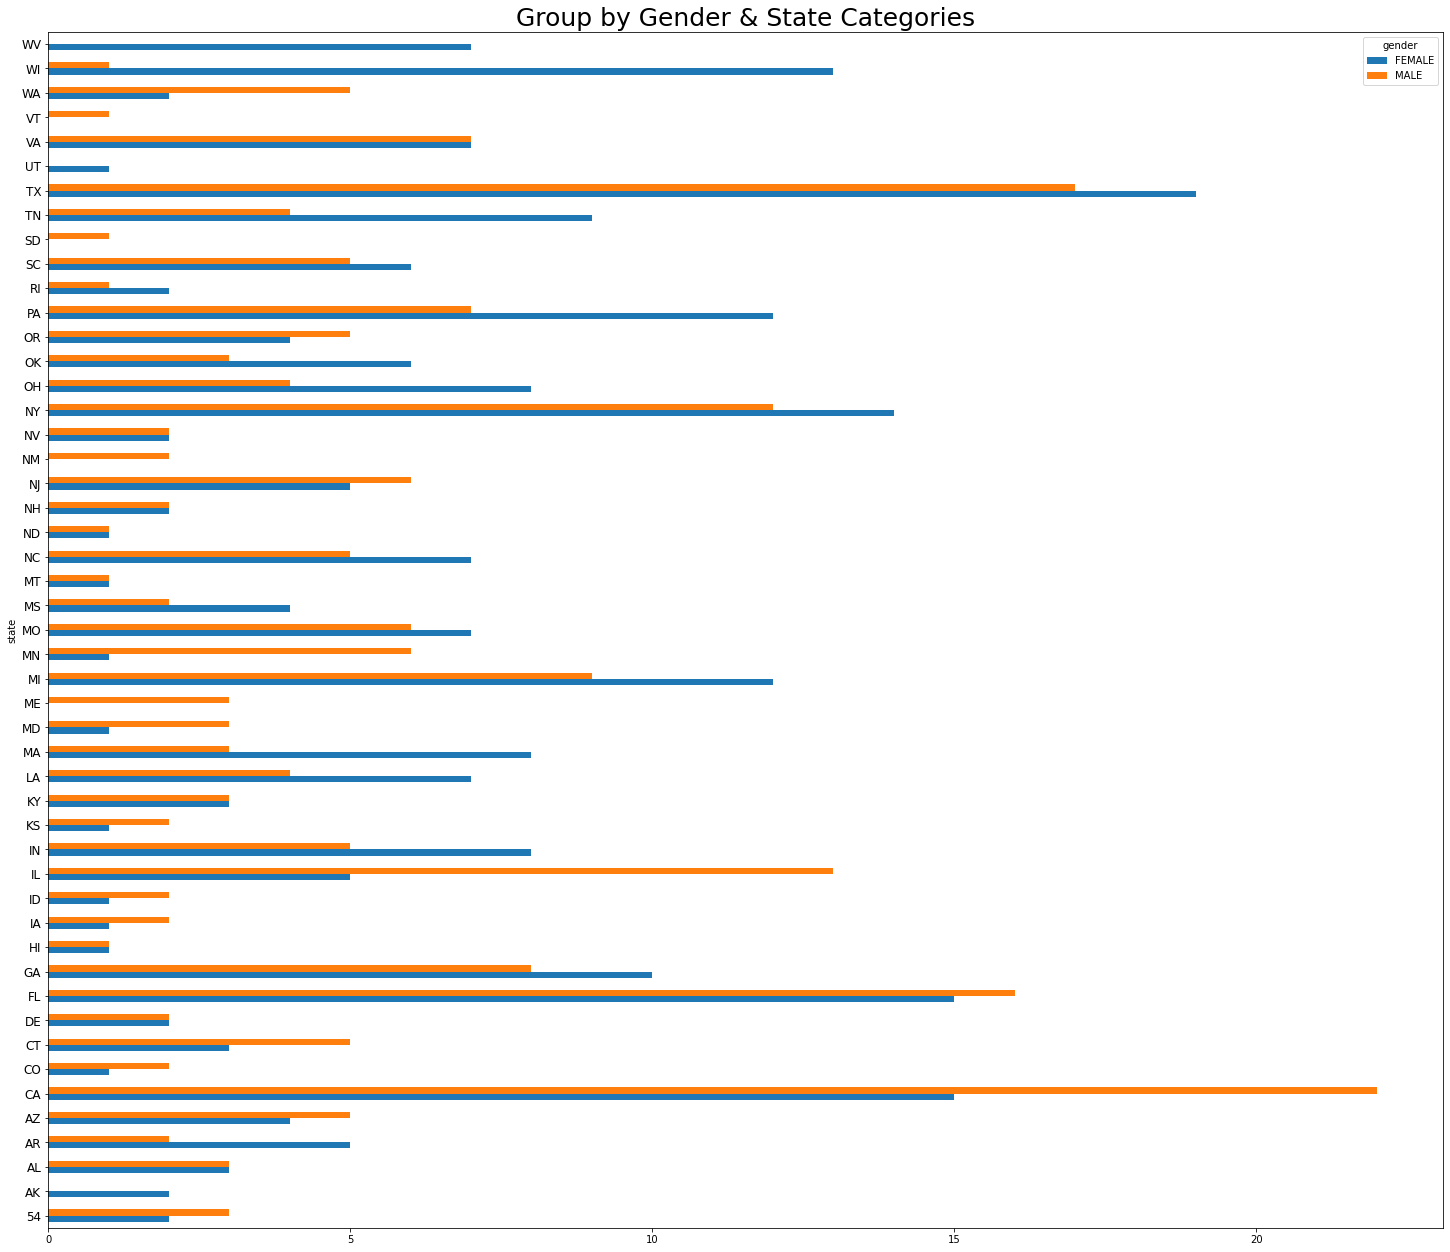

In [161]:
import pandas as pd

barh_table = pd.crosstab(selective_patient_df.state, selective_patient_df.gender)
ax = barh_table.plot.barh(figsize=(25,22), title='Group by Gender & State Categories')
ax.yaxis.set_tick_params(labelsize='large')
ax.title.set_size(25)

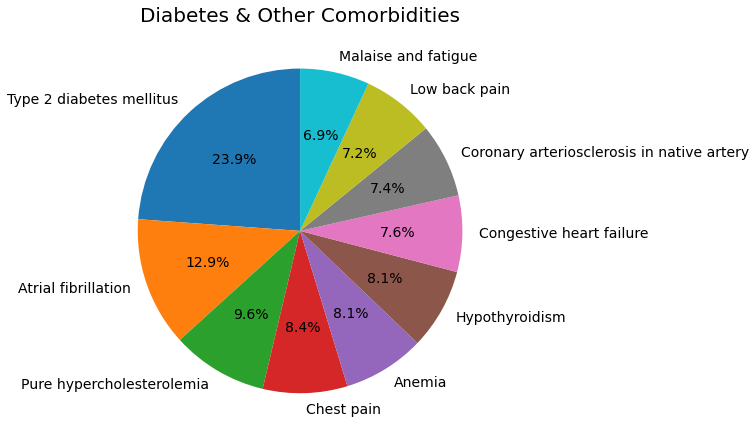

In [162]:
import matplotlib.pyplot as plt

# Group Data by Conditions
co_mini_df = condOcc_df[['conditionname', 'pid']]
co_group_df = co_mini_df.groupby(['conditionname']).count()
co_group_df.rename(columns = {'pid':'count'}, inplace = True)

# Sort & Pick the top 10 conditions
co_group_df.sort_values(by=['count'], inplace=True, ascending=False)
co_group_df_top10 = co_group_df.head(10)
plt.figure(figsize=(16,8))

# plot pie chart
ax1 = plt.subplot(121)
co_group_df_top10.plot(kind='pie', y = 'count', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, legend = False, fontsize=14)

plt.title('Diabetes & Other Comorbidities', fontdict={'fontsize':20})
plt.axis('off')
plt.show()